In [1]:
import os
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel
from PIL import Image

d:\PyCharm_Projects\Scraping Dataset\generating-annotations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomStableDiffusion:
    def __init__(self, model_id="runwayml/stable-diffusion-v1-5", unet_path=None, device=None, torch_dtype=torch.float16, cache_dir="./models"):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch_dtype,
            scheduler=DDIMScheduler.from_pretrained(model_id, subfolder="scheduler", cache_dir=cache_dir),
            safety_checker=None,
            cache_dir=cache_dir
        ).to(self.device)

        # Заменяем UNet на кастомный (если указан путь)
        if unet_path:
            print(f"🔁 Loading custom UNet from: {unet_path}")
            unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", cache_dir=cache_dir)
            state_dict = torch.load(unet_path, map_location=self.device)
            unet.load_state_dict(state_dict)
            unet.to(self.device)
            self.pipe.unet = unet

    def generate(self, prompt, height=256, width=256, num_inference_steps=50, guidance_scale=7.5):
        with torch.autocast(self.device) if self.device == "cuda" else torch.no_grad():
            image = self.pipe(
                prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
            ).images[0]
            return image


In [4]:
from pathlib import Path

checkpoints_dir = Path('checkpoints')

In [3]:
generator = CustomStableDiffusion(
    model_id="runwayml/stable-diffusion-v1-5",
    unet_path=checkpoints_dir / "unet_epoch_10.pt"
)

Loading pipeline components...: 100%|██████████| 6/6 [10:46<00:00, 107.69s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


🔁 Loading custom UNet from: checkpoints/unet_epoch_10.pt


100%|██████████| 5/5 [00:53<00:00, 10.77s/it]


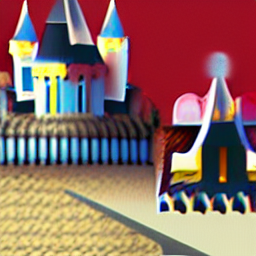

In [5]:
image = generator.generate("a fantasy castle surrounded by fog and mountains", num_inference_steps=5)
image